In [1]:
import numpy as np
import matplotlib.pyplot as plt
import logging

import dataset
import dataset_misc1d
import dataset_misc2d
import space
from symbols.const import ConstantSyntaxTree
from symbols.var import VariableSyntaxTree
from symbols.binop import BinaryOperatorSyntaxTree
from gp import corrector

SAMPLE_SIZE = 200
NOISE = 0.0

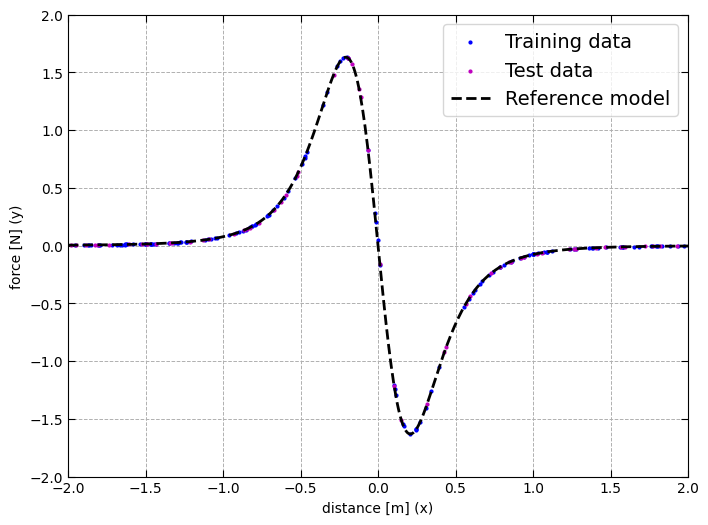

In [2]:
S = dataset_misc1d.MagmanDatasetScaled()
S.sample(size=SAMPLE_SIZE, noise=NOISE, mesh=False)
#S.load('../data/magman.csv')
S.split()
S.get_plotter().plot(width=8, height=6, plot_knowldege=False)

S_train = dataset.NumpyDataset(S)
S_test  = dataset.NumpyDataset(S, test=True)

X_mesh = S.spsampler.meshspace(S.xl, S.xu, 100)
meshspace = space.MeshSpace(X_mesh, S_train.X)

In [ ]:
backprop_node = ConstantSyntaxTree(2.0)
stree = BinaryOperatorSyntaxTree('/',
        BinaryOperatorSyntaxTree('*',
            ConstantSyntaxTree(-0.05),
            VariableSyntaxTree(),
        ),
        backprop_node
    )

corr = corrector.Corrector(S_train, S.knowledge, max_depth=5)
new_stree, new_node, C_pulled, y_pulled = corr.correct(stree, backprop_node)

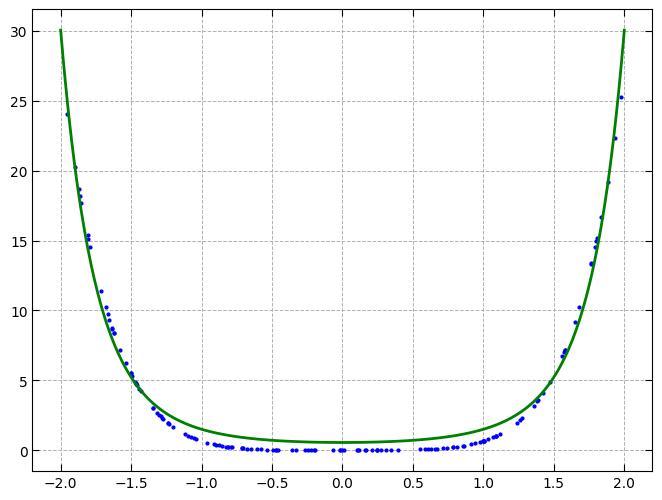

noroot
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]
(0,): [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]



In [4]:
S_backprop = dataset.NumpyDataset(S)
S_backprop.X = S_train.X
S_backprop.y = y_pulled

S_backprop.get_plotter().plot(width=8, height=6, model=new_node)

print(C_pulled)